### Loading relevant libraries

In [1]:
# regular imports
import os
import numpy as np
import pandas as pd
import time
import string
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# imports for scikit-learn & LDA
import sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures

# imports for scikit-learn & LDA
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig

# Plotly based imports for visualization
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Define the punctuations & stop words
PUNCTUATIONS = string.punctuation
STOPWORDS = list(STOP_WORDS)

# Load the spacy model installed (using the medium model)
NLP = spacy.load('en_core_web_md')

C:\cygwin64\home\darsh\Continuum\Anaconda3\lib\site-packages\socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable


C:\cygwin64\home\darsh\Continuum\Anaconda3\lib\site-packages\thinc\neural\train.py:7: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working

C:\cygwin64\home\darsh\Continuum\Anaconda3\lib\site-packages\thinc\check.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



In [2]:
# Define the working directory & raw input datasets
REL_PATH = './'
INFILE = '050319_acled_all.csv'

# Define the directory for saving LDA visualizations as HTML files
LDA_VIS_PATH = './lda_vis/'

# Read in the raw file
df = pd.read_csv(os.path.join(REL_PATH, INFILE))

### Pre-processing

In [3]:
# Parser & Tokenizer function for conlfict notes
parser = English()
def spacy_tokenizer(note):
    mytokens = parser(str(note))
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in STOPWORDS and word not in PUNCTUATIONS ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


In [4]:
tqdm.pandas()

# Parsing & Tokenizing the entire dataset
df["processed_notes"] = df["notes"].progress_apply(spacy_tokenizer)

100%|██████████| 509157/509157 [10:34<00:00, 802.87it/s] 


### Class definition for LDA Models

In [5]:
class LDA_Model(object):
    """docstring for LDA_Model."""

    def __init__(self, num_topics, max_iter, vectorizer_type):
        super(LDA_Model, self).__init__()
        self.num_topics = num_topics
        self.max_iter = max_iter
        self.lda = LatentDirichletAllocation(n_components=self.num_topics,
                                             max_iter=self.max_iter,
                                             learning_method='online',
                                             learning_offset=50.,
                                             random_state=0)
        self.count_vectorizer = CountVectorizer(min_df=5, max_df=0.9,
                                                stop_words=STOPWORDS,
                                                lowercase=True,
                                                token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
        self.tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                                stop_words=STOPWORDS)
        # Choose vectorizer type based on flag passed in
        self.vectorizer_type = vectorizer_type
        if self.vectorizer_type == 'tfidf':
            self.vectorizer = self.tfidf_vectorizer
        else:
            self.vectorizer = self.count_vectorizer

    def vectorize_data(self, list):
        self.data_vectorized = self.vectorizer.fit_transform(tqdm(list))

    def train_lda(self):
        self.lda.fit(self.data_vectorized)

    def selected_topics(self, top_n=10):
        for idx, topic in enumerate(self.lda.components_):
            print("LDA Model:")
            print("Topic %d:" % (idx))
            print([(self.vectorizer.get_feature_names()[i], topic[i]) \
                               for i in topic.argsort()[:-top_n - 1:-1]])

    def visualize(self, out_vis_file):
        # Build a Visualization using pyLDAvis
        self.dash = pyLDAvis.sklearn.prepare(self.lda,
                                             self.data_vectorized,
                                             self.vectorizer,
                                             mds='tsne')
        # Save the Visualization built as an HTML file
        pyLDAvis.save_html(self.dash, fileobj=os.path.join(LDA_VIS_PATH, out_vis_file))


<>:16: DeprecationWarning:

invalid escape sequence \-

<>:16: DeprecationWarning:

invalid escape sequence \-

<>:16: DeprecationWarning:

invalid escape sequence \-

<ipython-input-5-82b98bec0574>:16: DeprecationWarning:

invalid escape sequence \-



### Model Runs

In [6]:
# Define Hyperparameters
grid = {'word2vec': {'dataset': ['full', '100+'], 
                     'tokens': ['unigrams', 'bigrams'],
                     'num_topics': [3, 5, 7, 10, 15],
                     'max_iter': [2, 5, 10],
                     'vectorizer_type': ['count', 'tfidf']
                    },
        'custom':  {'dataset': ['full', '100+'], 
                     'tokens': ['unigrams', 'bigrams'],
                     'num_topics': [3, 5, 7, 10, 15],
                     'max_iter': [2, 5, 10],
                     'vectorizer_type': ['count', 'tfidf']
                    }
       }

#### Model 1: 3 topics, 2 iterations, count vectorizer

In [7]:
# Test parameters
num_topics = 3
max_iter = 2
vectorizer_type = 'count'

In [8]:
# Instantiate the LDA Model
lda_3_2_count = LDA_Model(num_topics, max_iter, vectorizer_type)

In [9]:
# Vectorize Data
lda_3_2_count.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:18<00:00, 27826.77it/s]


In [10]:
%%time

# Train the model
lda_3_2_count.train_lda()

Wall time: 7min 55s


In [11]:
%%time

# Build & save Visualization as HTML
lda_3_2_count.visualize('lda_3_2_count_full_unigram.html')

Wall time: 19min 12s


#### Model 2: 3 topics, 5 iterations, count vectorizer

In [12]:
# Instantiate the LDA Model
lda_3_5_count = LDA_Model(num_topics=3, max_iter=5, vectorizer_type='count')

# Vectorize Data
lda_3_5_count.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:17<00:00, 28776.34it/s]


In [13]:
%%time

# Train the model
lda_3_5_count.train_lda()

Wall time: 16min 51s


In [14]:
%%time

# Build & save Visualization as HTML
lda_3_5_count.visualize('lda_3_5_count_full_unigram.html')

Wall time: 21min 45s


#### Model 3: 3 topics, 2 iterations, tfidf vectorizer

In [15]:
# Instantiate the LDA Model
lda_3_2_tfidf = LDA_Model(num_topics=3, max_iter=2, vectorizer_type='tfidf')

# Vectorize Data
lda_3_2_tfidf.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:21<00:00, 23794.43it/s]


In [16]:
%%time

# Train the model
lda_3_2_tfidf.train_lda()

Wall time: 8min 31s


In [17]:
%%time

# Build & save Visualization as HTML
lda_3_2_tfidf.visualize('lda_3_2_tfidf_full_unigram.html')

Wall time: 42min 57s


#### Model 4: 5 topics, 2 iterations, count vectorizer

In [18]:
# Instantiate the LDA Model
lda_5_2_count = LDA_Model(num_topics=5, max_iter=2, vectorizer_type='count')

# Vectorize Data
lda_5_2_count.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:18<00:00, 27116.46it/s]


In [19]:
%%time

# Train the model
lda_5_2_count.train_lda()

Wall time: 9min 5s


In [20]:
%%time

# Build & save Visualization as HTML
lda_5_2_count.visualize('lda_5_2_count_full_unigram.html')

Wall time: 18min 29s


#### Model 5: 5 topics, 2 iterations, tfidf vectorizer

In [21]:
# Instantiate the LDA Model
lda_5_2_tfidf = LDA_Model(num_topics=5, max_iter=2, vectorizer_type='tfidf')

# Vectorize Data
lda_5_2_tfidf.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:12<00:00, 42061.73it/s]


In [22]:
%%time

# Train the model
lda_5_2_tfidf.train_lda()

Wall time: 4min 51s


In [23]:
%%time

# Build & save Visualization as HTML
lda_5_2_tfidf.visualize('lda_5_2_tfidf_full_unigram.html')

Wall time: 25min 48s


#### Model 6: 7 topics, 2 iterations, count vectorizer

In [24]:
# Instantiate the LDA Model
lda_7_2_count = LDA_Model(num_topics=7, max_iter=2, vectorizer_type='count')

# Vectorize Data
lda_7_2_count.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:07<00:00, 70571.07it/s] 


In [25]:
%%time

# Train the model
lda_7_2_count.train_lda()

Wall time: 4min 29s


In [26]:
%%time

# Build & save Visualization as HTML
lda_7_2_count.visualize('lda_7_2_count_full_unigram.html')

Wall time: 13min 32s


#### Model 7: 7 topics, 2 iterations, tfidf vectorizer

In [27]:
# Instantiate the LDA Model
lda_7_2_tfidf = LDA_Model(num_topics=7, max_iter=2, vectorizer_type='tfidf')

# Vectorize Data
lda_7_2_tfidf.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:08<00:00, 58700.73it/s]


In [28]:
%%time

# Train the model
lda_7_2_tfidf.train_lda()

Wall time: 5min 38s


In [29]:
%%time

# Build & save Visualization as HTML
lda_7_2_tfidf.visualize('lda_7_2_tfidf_full_unigram.html')

Wall time: 25min 28s


#### Model 8: 10 topics, 2 iterations, count vectorizer

In [30]:
# Instantiate the LDA Model
lda_10_2_count = LDA_Model(num_topics=10, max_iter=2, vectorizer_type='count')

# Vectorize Data
lda_10_2_count.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:07<00:00, 69185.55it/s]


In [31]:
%%time

# Train the model
lda_10_2_count.train_lda()

Wall time: 5min 24s


In [32]:
%%time

# Build & save Visualization as HTML
lda_10_2_count.visualize('lda_10_2_count_full_unigram.html')

Wall time: 14min 12s


#### Model 9: 10 topics, 2 iterations, tfidf vectorizer

In [33]:
# Instantiate the LDA Model
lda_10_2_tfidf = LDA_Model(num_topics=10, max_iter=2, vectorizer_type='tfidf')

# Vectorize Data
lda_10_2_tfidf.vectorize_data(df["processed_notes"])

100%|██████████| 509157/509157 [00:08<00:00, 57884.97it/s]


In [34]:
%%time

# Train the model
lda_10_2_tfidf.train_lda()

Wall time: 7min 55s


In [35]:
%%time

# Build & save Visualization as HTML
lda_10_2_tfidf.visualize('lda_10_2_tfidf_full_unigram.html')

Wall time: 26min


### Saving the LDA Models as pickles

In [37]:
import pickle
pickle_path = './lda_pickles/'

#### Define functions to create and load model pickles

In [54]:
pickle_dict = {lda_3_2_count : 'lda_3_2_count.pkl',
               lda_3_5_count : 'lda_3_5_count.pkl',
               lda_3_2_tfidf : 'lda_3_2_tfidf.pkl',
               lda_5_2_count : 'lda_5_2_count.pkl',
               lda_5_2_tfidf : 'lda_5_2_tfidf.pkl',
               lda_7_2_count : 'lda_7_2_count.pkl',
               lda_7_2_tfidf : 'lda_7_2_tfidf.pkl',
               lda_10_2_count: 'lda_10_2_count.pkl',
               lda_10_2_tfidf: 'lda_10_2_tfidf.pkl'
               }

def pickle_model(lda_obj):
    
    pkl_name = pickle_dict[lda_obj]
    
    # Open the file to save as pkl file
    lda_model_pkl = open(os.path.join(pickle_path, pkl_name), 'wb')
    pickle.dump(lda_obj, lda_model_pkl)

    # Close the pickle instances
    lda_model_pkl.close()

def load_model(lda_obj):
    
    pkl_name = pickle_dict[lda_obj]
    
    # Loading the saved model pickle
    lda_model_pkl = open(os.path.join(pickle_path, pkl_name), 'rb')
    lda_obj = pickle.load(lda_model_pkl)
    
    return lda_obj

##### Pickle all Models

In [59]:
for lda_obj in tqdm(pickle_dict.keys()):
    pickle_model(lda_obj)

100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


### Mapping the LDA results back on to the dataset

##### Define function to map Model results back on to the main dataset

In [157]:
def map_lda_results(lda_obj):
    '''
    Hard Clustering done based on the Topic / Cluster with the 
    highest confitional probability p(Topic | Conflict Note)
    '''
    
    colname = pickle_dict[lda_obj][:-4]
    
    # Call LDA.Transform to get p(Topic | Conflict Note)
    results = lda_obj.lda.transform(lda_obj.data_vectorized)
    
    # return Series with index of max value along the 2nd axis
    df[colname] = pd.Series(np.argmax(results, axis=1) + 1)

##### Map results for all Models

In [158]:
for lda_obj in tqdm(pickle_dict.keys()):
    map_lda_results(lda_obj)

100%|██████████| 9/9 [06:26<00:00, 38.40s/it]


### Visualizations for Hard Clustering

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

  0%|          | 0/9 [00:00<?, ?it/s]

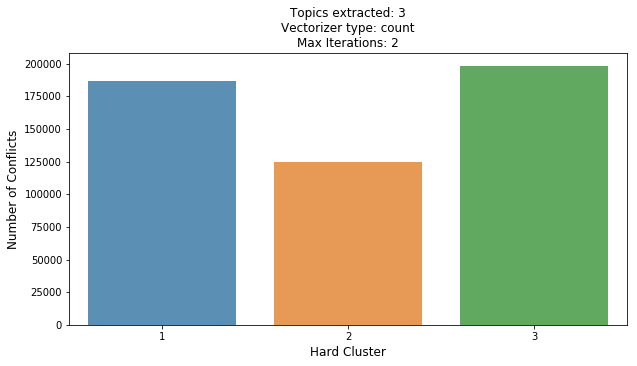

 11%|█         | 1/9 [00:00<00:01,  5.45it/s]

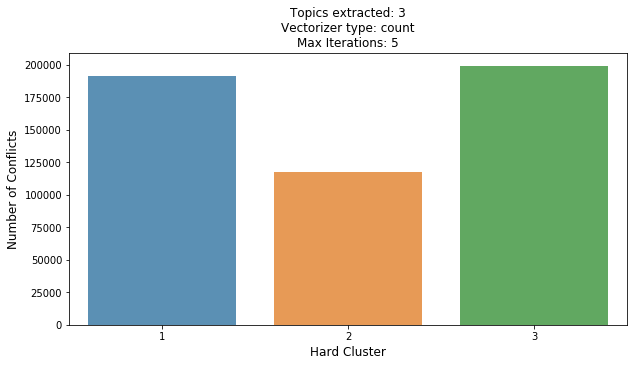

 22%|██▏       | 2/9 [00:00<00:01,  5.61it/s]

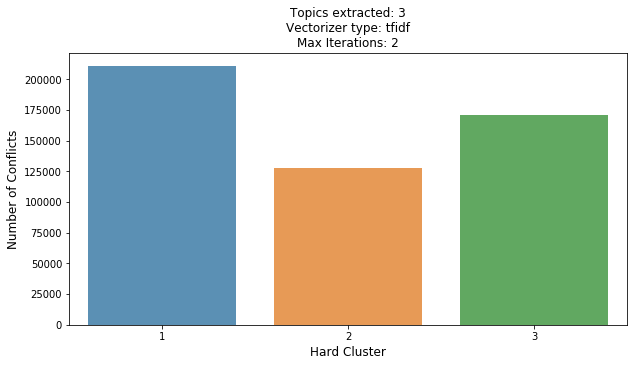

 33%|███▎      | 3/9 [00:00<00:01,  5.61it/s]

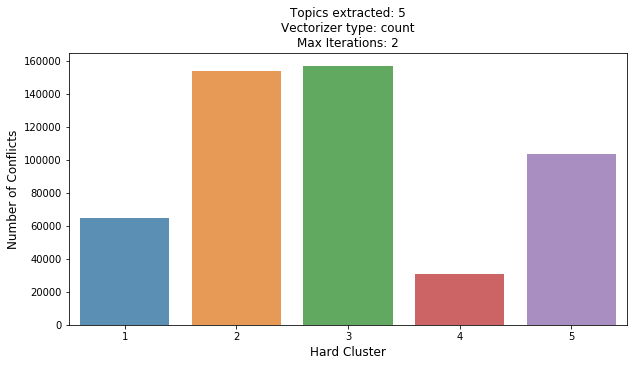

 44%|████▍     | 4/9 [00:00<00:00,  6.05it/s]

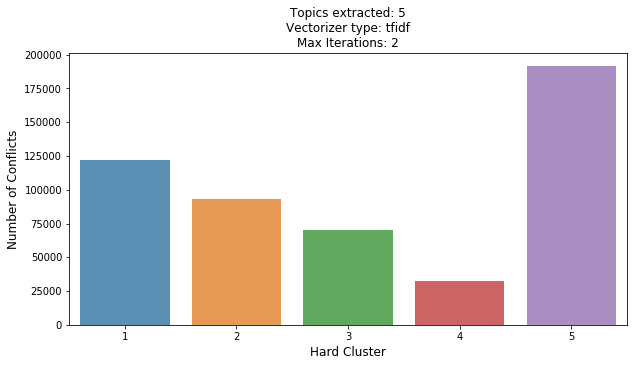

 56%|█████▌    | 5/9 [00:00<00:00,  6.27it/s]

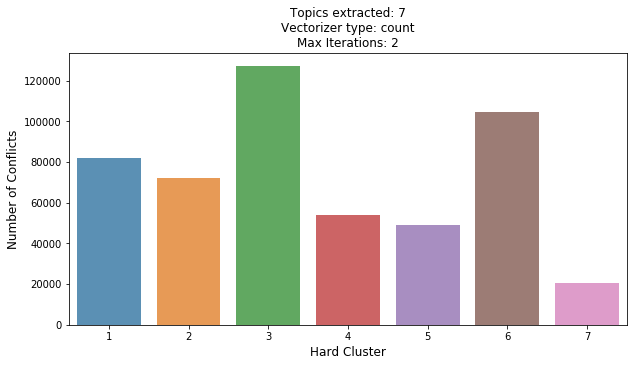

 67%|██████▋   | 6/9 [00:00<00:00,  6.00it/s]

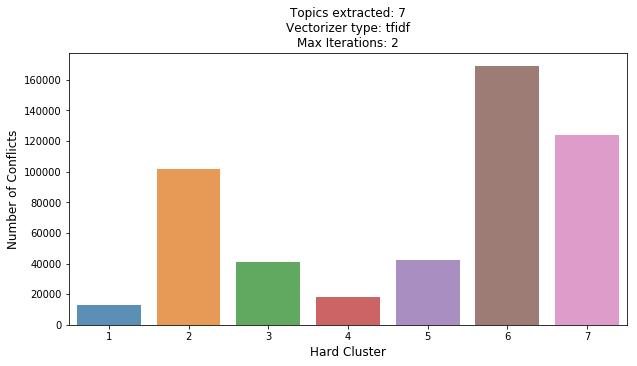

 78%|███████▊  | 7/9 [00:01<00:00,  5.41it/s]

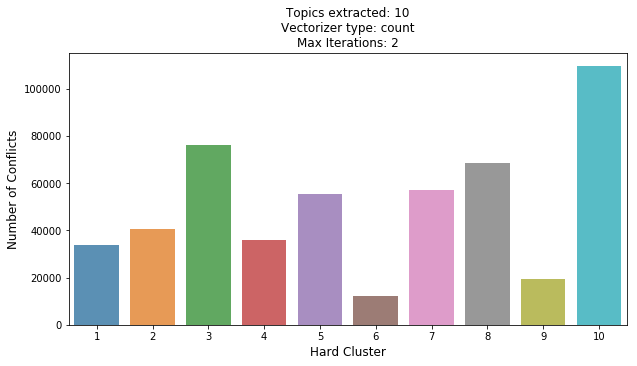

 89%|████████▉ | 8/9 [00:01<00:00,  5.52it/s]

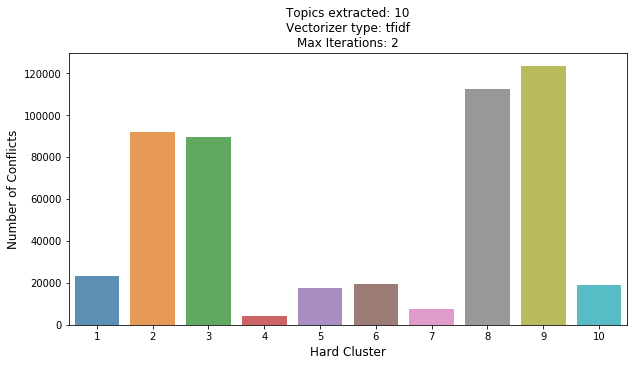

100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


In [160]:
# Check Distribution of Topics
for lda_obj in tqdm(pickle_dict.keys()):
    
    colname = pickle_dict[lda_obj][:-4]
    topic_count = df[colname].value_counts()
    
    plt.figure(figsize=(10,5))
    sns.barplot(topic_count.index, topic_count.values, alpha=0.8)
    plt.title('Topics extracted: ' + str(lda_obj.num_topics) + '\n' +
              'Vectorizer type: ' + str(lda_obj.vectorizer_type) + '\n' +
              'Max Iterations: ' + str(lda_obj.max_iter)
             )
    plt.ylabel('Number of Conflicts', fontsize=12)
    plt.xlabel('Hard Cluster', fontsize=12)
    plt.show()

In [161]:
df.columns

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3',
       'processed_notes', 'lda_3_2_count', 'lda_3_5_count', 'lda_3_2_tfidf',
       'lda_5_2_count', 'lda_5_2_tfidf', 'lda_7_2_count', 'lda_7_2_tfidf',
       'lda_10_2_count', 'lda_10_2_tfidf'],
      dtype='object')

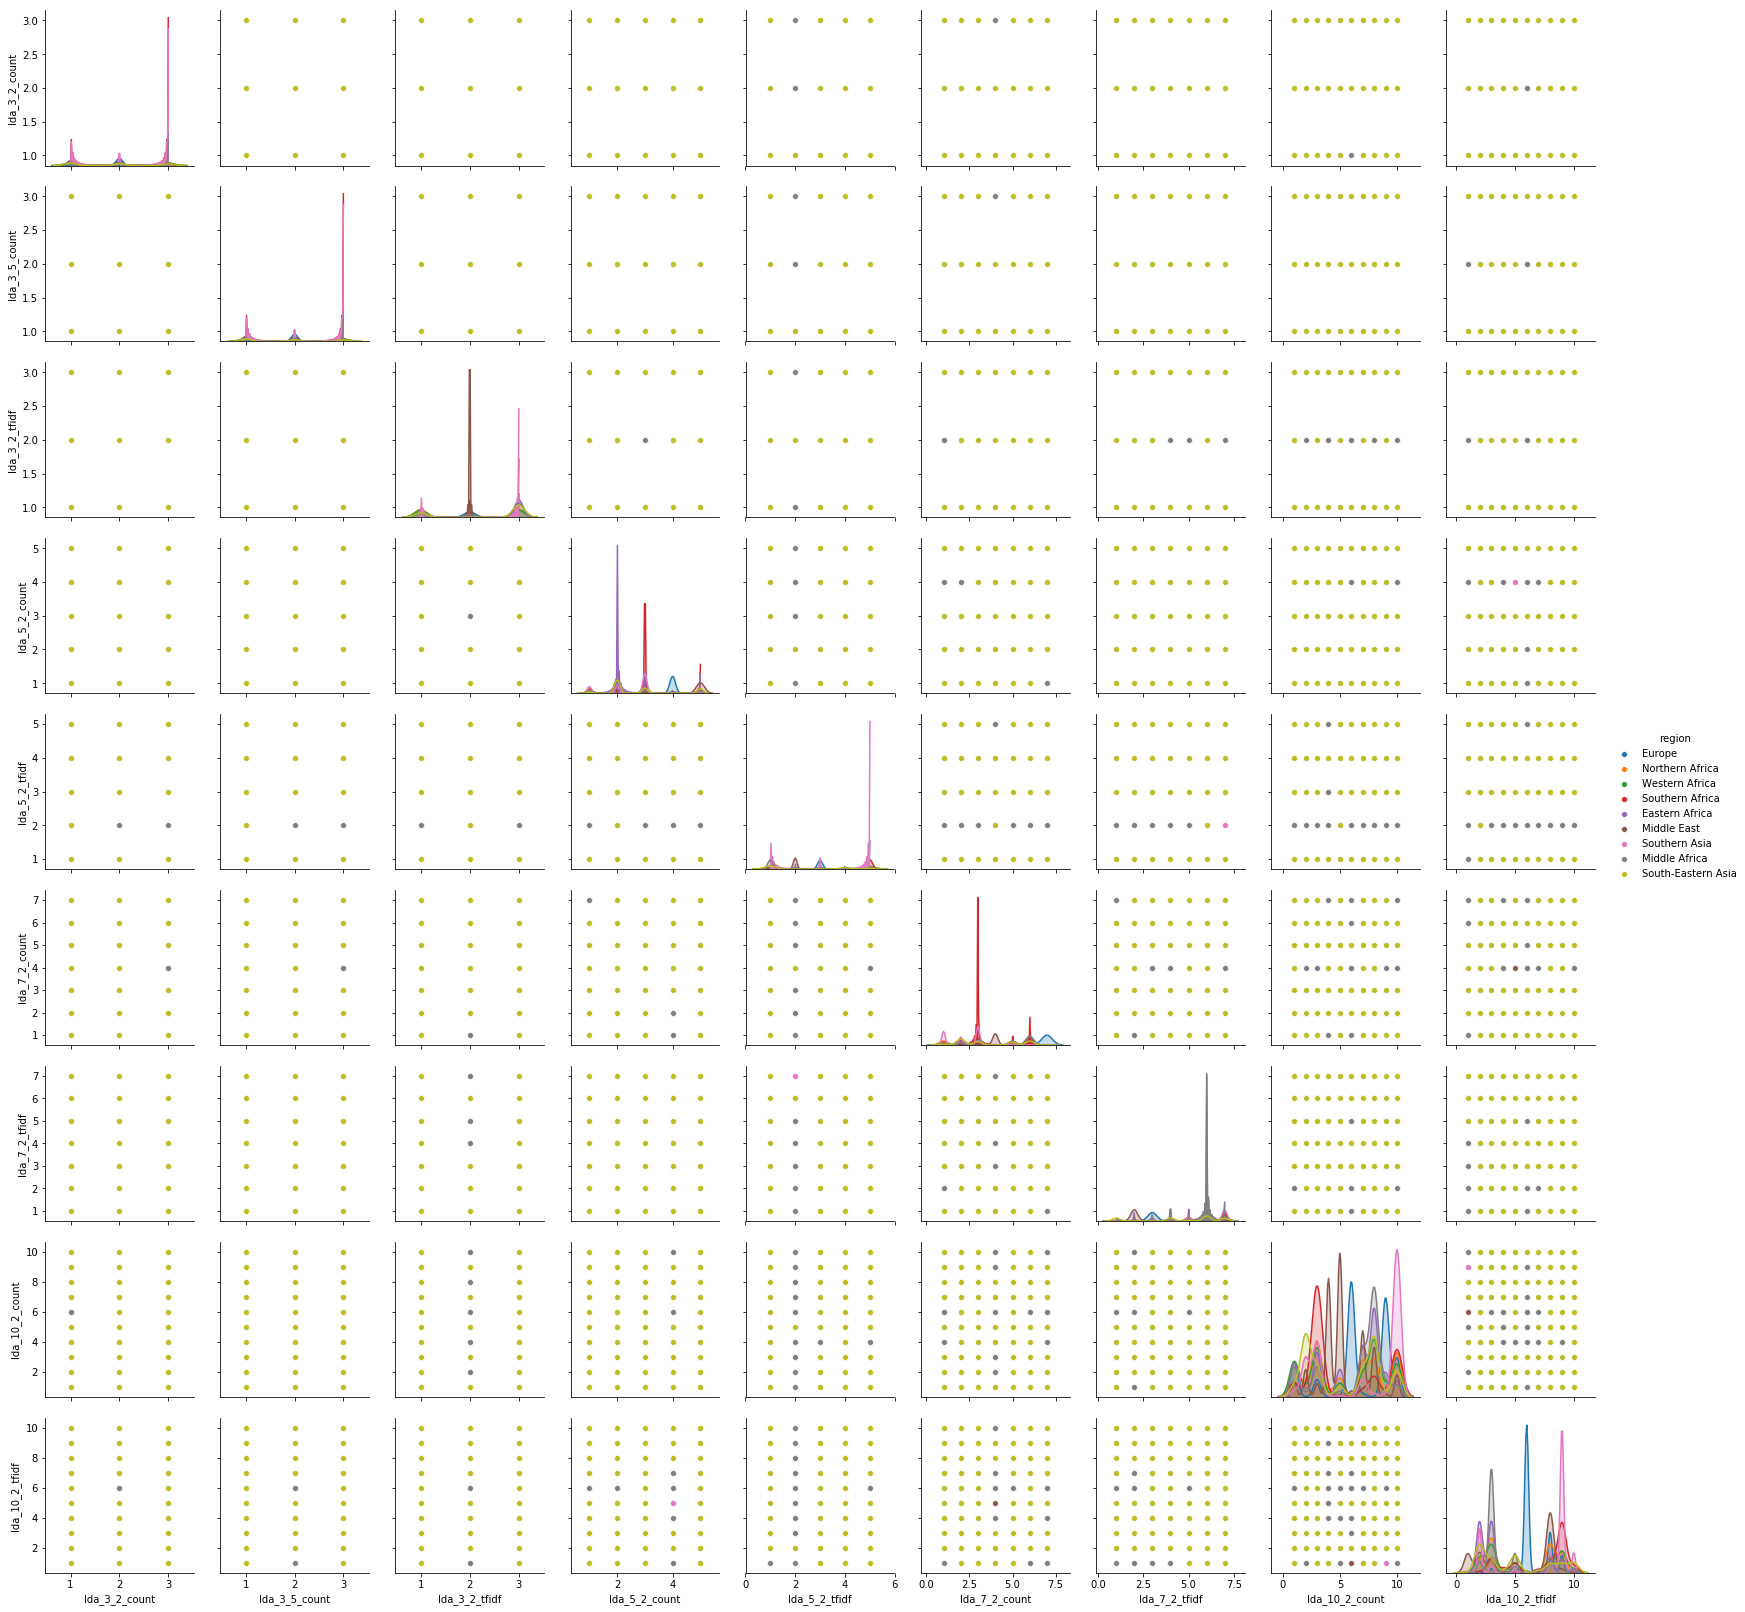

In [163]:
sns.pairplot(df[['region', 'lda_3_2_count', 'lda_3_5_count', 'lda_3_2_tfidf',
       'lda_5_2_count', 'lda_5_2_tfidf', 'lda_7_2_count', 'lda_7_2_tfidf',
       'lda_10_2_count', 'lda_10_2_tfidf']], hue='region')

### Define function to create FacetGrid topic distributions plots

In [193]:
# Define a function to create the distributions trends
def topics_by_region(category, lda_obj):
    '''
    Create FacetGrid plots with Seaborn to visualize topic distribution trends by Region
    '''
    
    # ordered list by descending number of conflicts
    ordered_catg = df[category].value_counts().index

    colname = pickle_dict[lda_obj][:-4]
    check = df.groupby([category, 'year', colname]).size().reset_index().rename(columns = {0: 'conflicts', 
                                                                                           colname: 'topic'})

    # Define the Factegrid
    g = sns.FacetGrid(check, 
                      col=category, col_wrap=3, 
                      col_order=ordered_catg,
                      hue="topic")
    g.map(plt.plot, "year", "conflicts", alpha=.5)
    
    # Set theme & other options
    g.add_legend();
    g.set_axis_labels("Year of Conflict", "No. of Conflicts")
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(str(lda_obj.num_topics) + ' Topics | ' + 
                   str(lda_obj.vectorizer_type).upper() + ' Vectorizer | ' + 
                   str(lda_obj.max_iter) + ' Max Iterations | ' + 
                   'by ' + category
                  )
    
    # Save file as .png
    g.savefig(os.path.join(LDA_VIS_PATH, 'distributions/', colname + '_by_' + category + '.png'))

#### Topic Distributions by Region

100%|██████████| 9/9 [00:13<00:00,  1.62s/it]


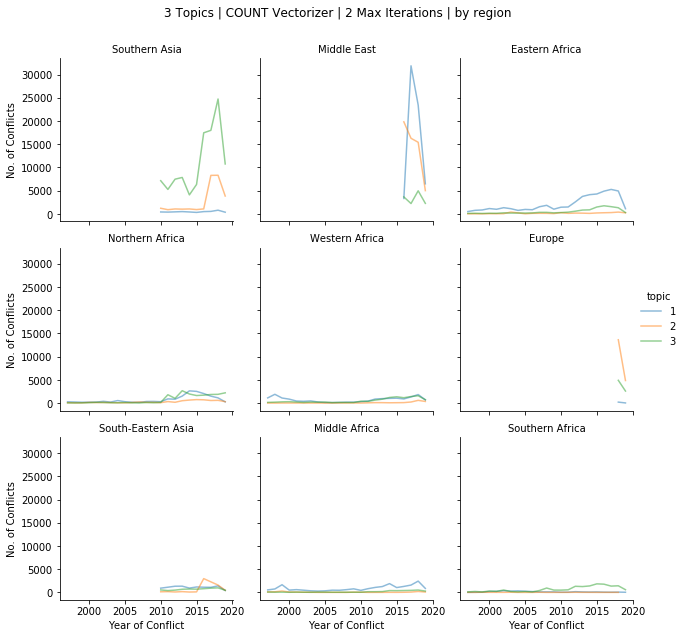

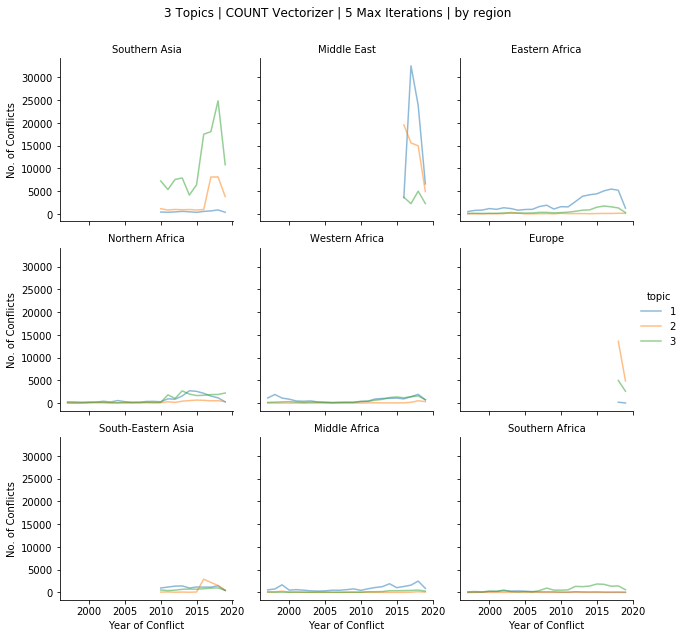

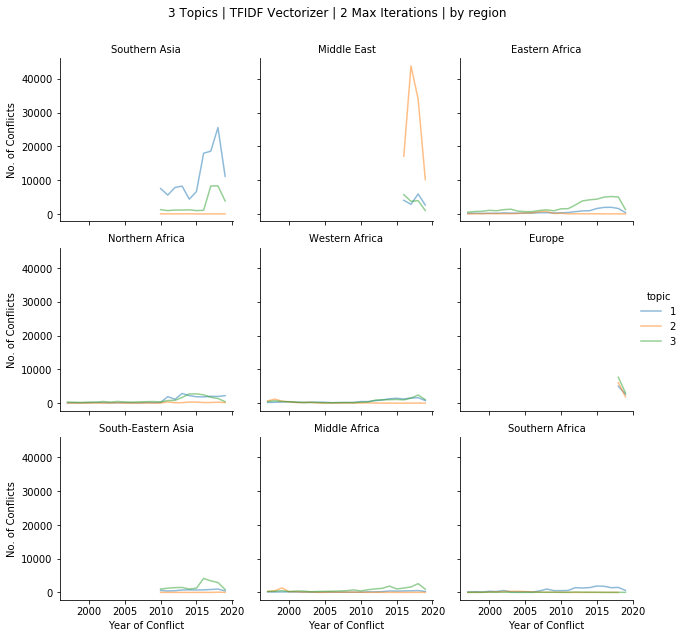

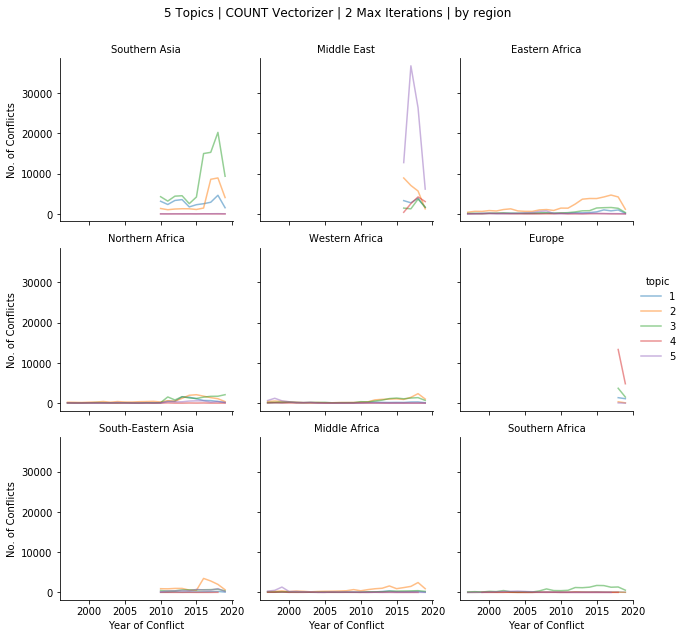

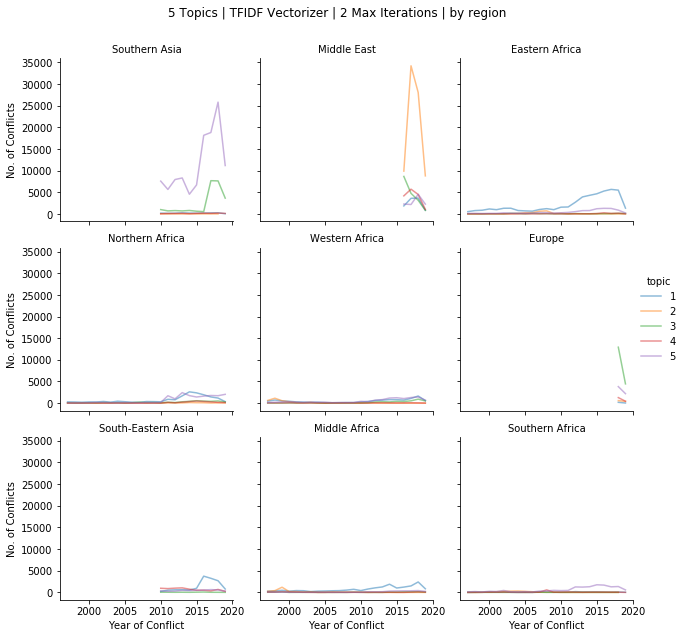

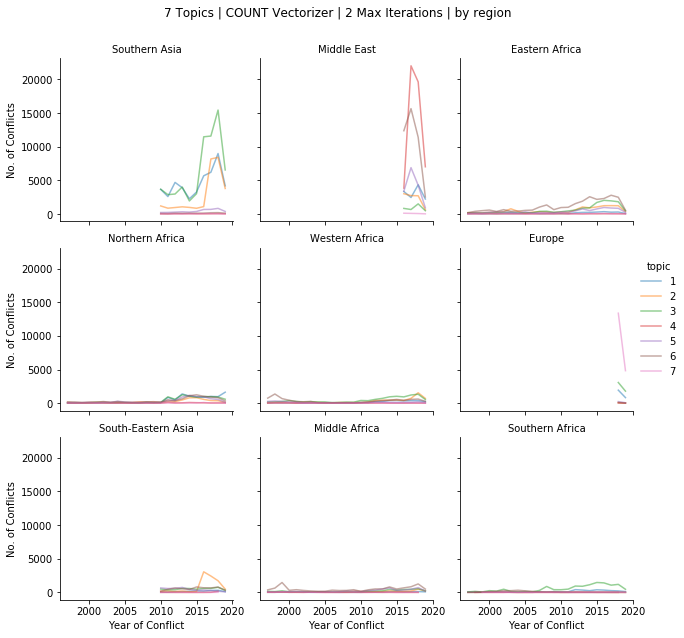

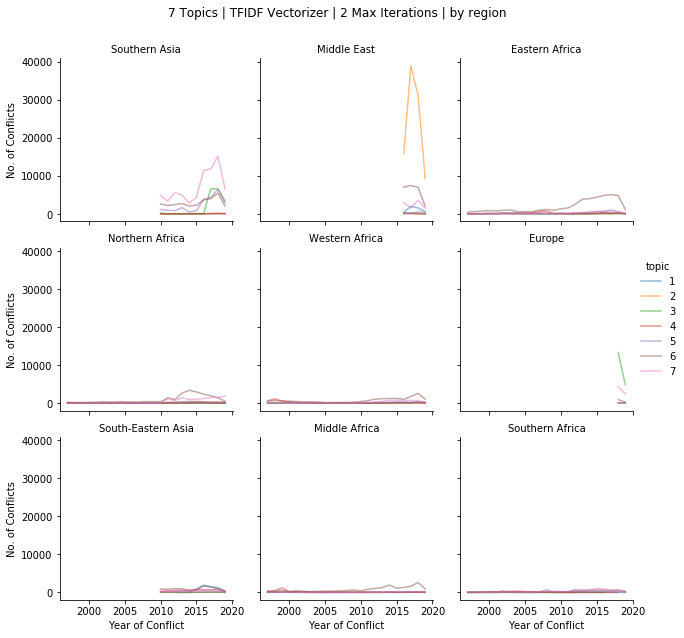

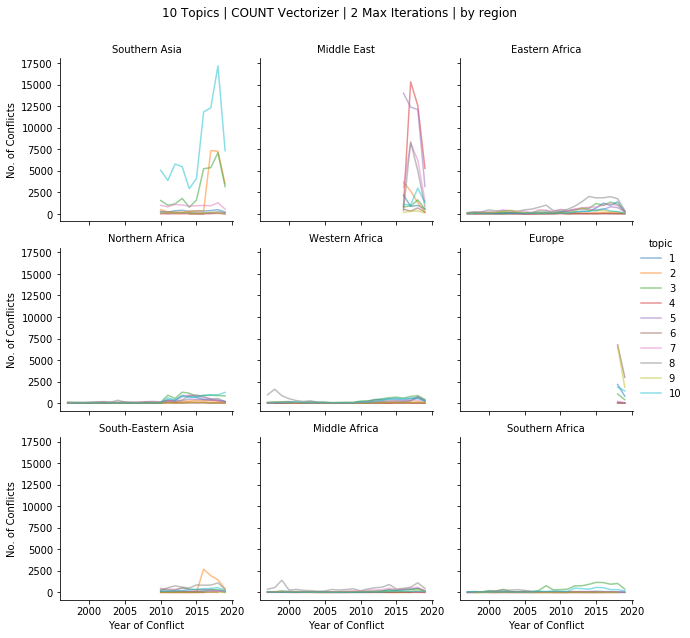

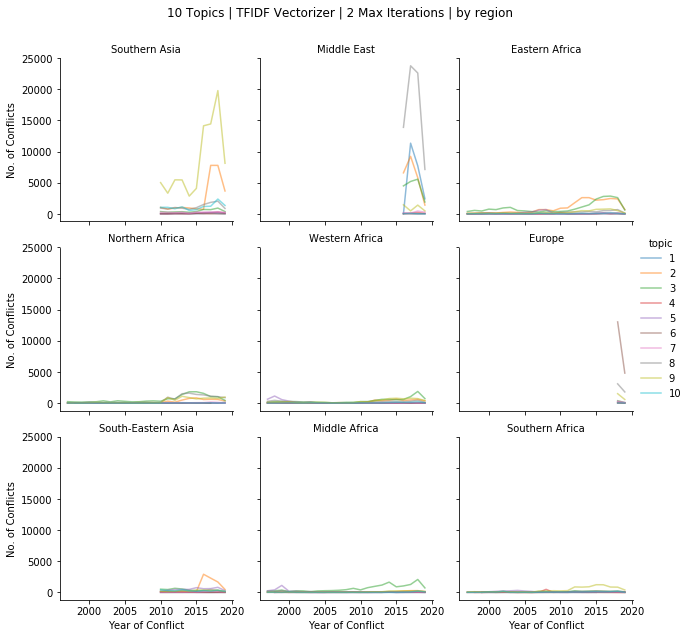

In [194]:
for lda_obj in tqdm(pickle_dict.keys()):
    topics_by_region('region', lda_obj)

#### Topic Distributions by Event Type

100%|██████████| 9/9 [00:09<00:00,  1.15s/it]


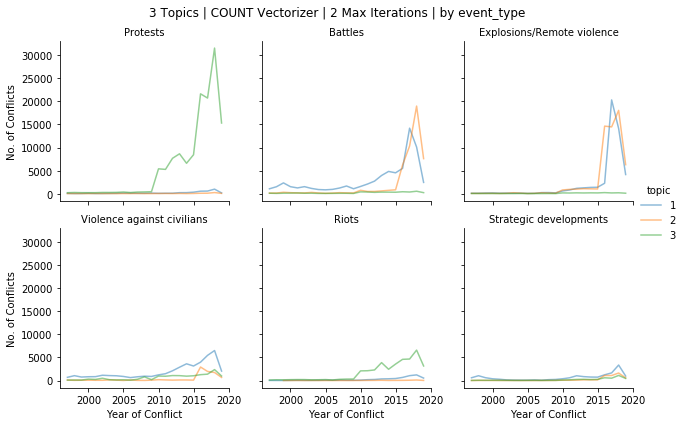

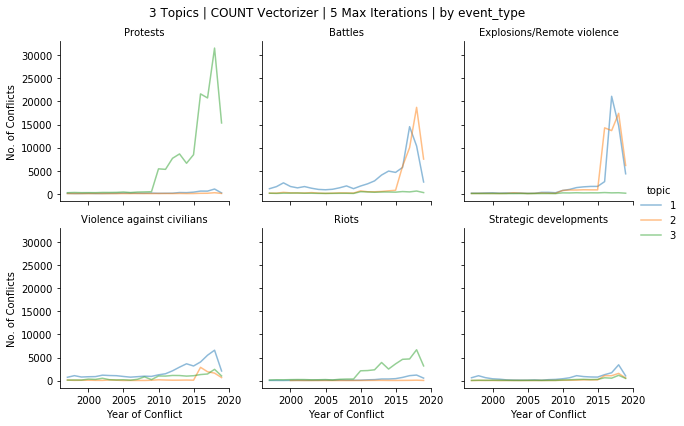

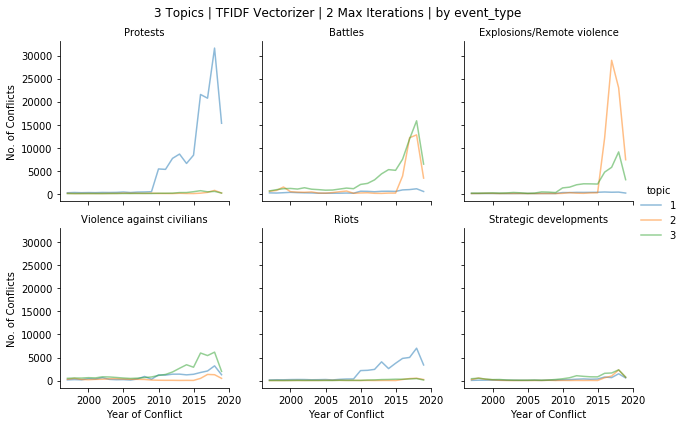

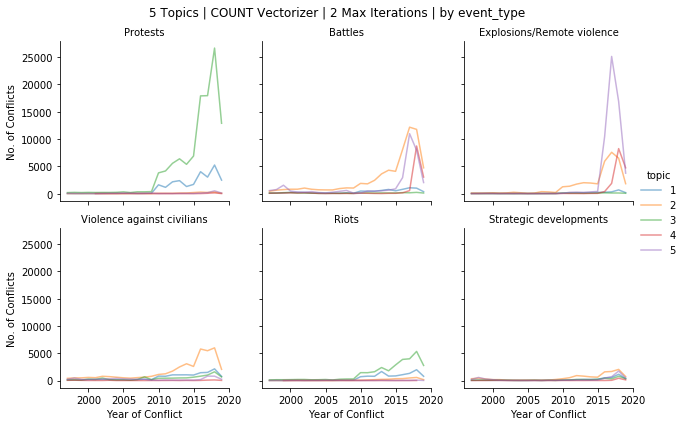

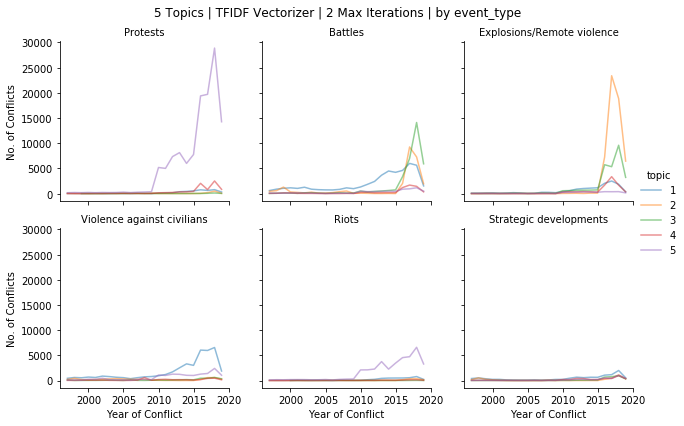

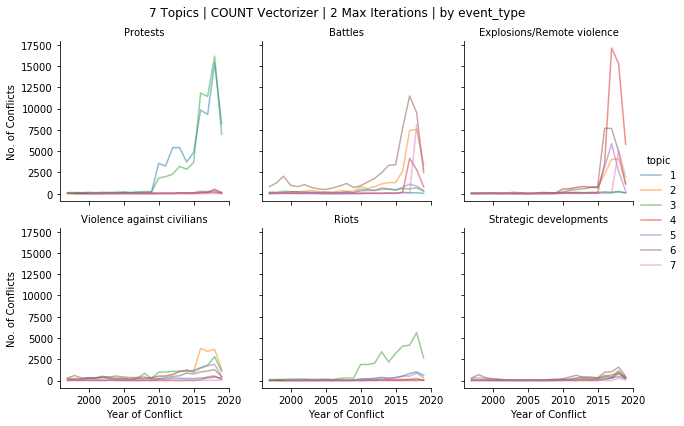

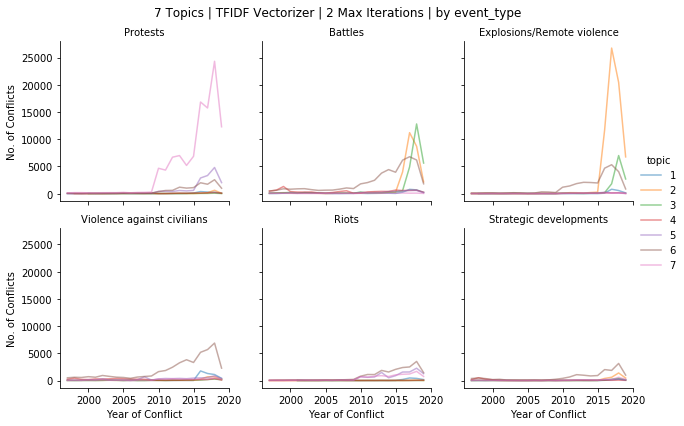

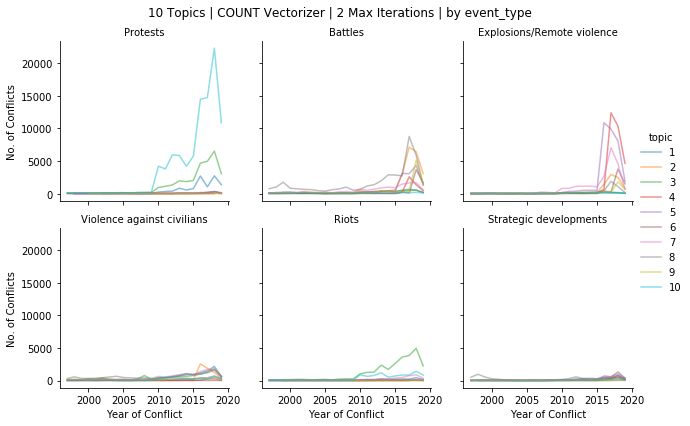

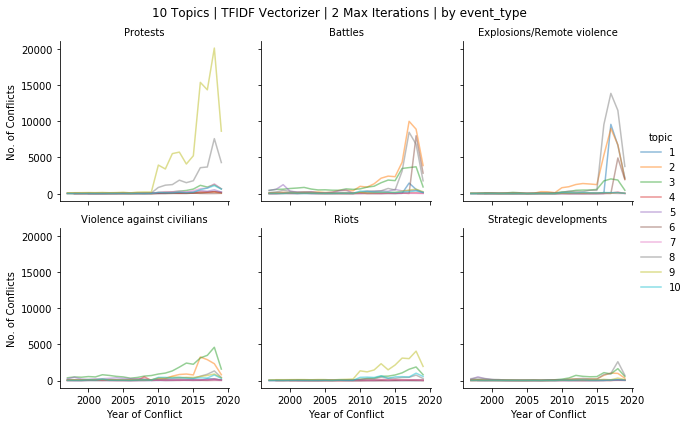

In [196]:
for lda_obj in tqdm(pickle_dict.keys()):
    topics_by_region('event_type', lda_obj)